# Choosing and Explaining Likely Caravan Insurance Customers


Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used: 
* dplyr
* ggplot2
* reshape2
* lattice
* MASS
* caret
* glmnet
* RColorBrewer
* pROC

## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Evaluation](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>

My goal with this project is to determine the most important factors in determining who will buy caravan insurance. I will then use these factors to build a prediction model. Finally, I wish to obtain a general profile of customer which is more likely to buy caravan insurance for marketing purposes.

####  i) Reading in Data

In [6]:
library("dplyr")
library("ggplot2")
library("reshape2")
library("lattice")
library("MASS")
library("caret")
library("glmnet")
library("RColorBrewer")
library("pROC")

In [7]:
train=read.table(sep = "\t",file = "ticdata2000.txt")
test=read.table(sep = "\t",file = "ticeval2000.txt")
target=read.table(sep = "\t",file = "tictgts2000.txt")

In [8]:
# remove customer types and subtypes, as will not be using them
train=train[,-c(1,5)]

# customers who bought insurance
insGroup=filter(train, V86==1)

# customers who did not buy insurance
noInsGroup=filter(train, V86!=1)

dim(insGroup)

[1] 348  84

In [9]:
print(dim(insGroup))
print(dim(train))

[1] 348  84
[1] 5822   84


About 348 or 6% of the individuals in the training dataset bought caravan insurance.

## 2. Data Exploration<a class="anchor" id="sec_2"></a>

#### i) Subsetting Variables

The insurance company dataset was very complex with 86 attributes. Additionally, most of these attributes are heavily correlated to each other. In order to simplify the exploration process, I decided to make use of lasso regression, to reduce the set of variables. When we have correlated variables, lasso regression works to select the most variable and set the others to zero.

In [10]:
#convert training data to matrix format
formulaMatrix = model.matrix(V86~.,train)[,-1]
# use cross validation to find set of variables which minimizes mse
cv.out <- cv.glmnet(formulaMatrix,train$V86,alpha=1,family='binomial',type.measure = 'mse' )
#plot result


The lambda that minimizes the mean squared error leaves us with close to 20 variables.

*Note: I did not set seed when running cross-validation, hence the initial set of variables and plot might be different from the set used in my analysis.

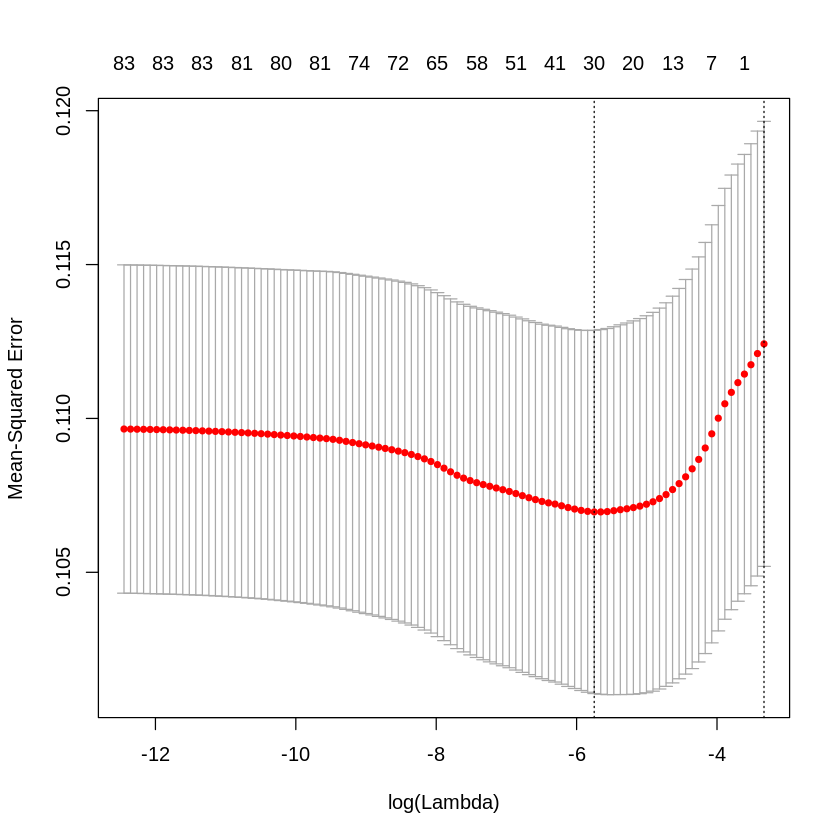

In [175]:
plot(cv.out)

In [176]:
lambda = cv.out$lambda.min
#regression coefficients
lassoCoeffs=coef(cv.out,s=lambda)

variables=lassoCoeffs@Dimnames[[1]][which(lassoCoeffs != 0 ) ][-1]

Below are the variables the Lasso regression has identified as the most important for prediction.

In [11]:
#set variables to output from original run of lasso regression
variables=c('V10','V16','V18','V21','V22','V30','V32','V42','V43','V44','V47','V58','V59','V82','V83','V85')

#### ii) Exploring Extracted Features

We will take a closer look at the variables below.

In [23]:
plotFeature =function(start, finish, rows=3, cols=4) {
    par(mfrow = c(rows,cols)) 
    for ( col in variables[ seq(start,finish) ] ) {
        # obtain levels 
        levels=sort(unique(train[,col]))
        
        # obtain the mean insurance bought by feature
        means=aggregate(train, by=list(train[,col]), FUN ="mean")[,"V86"]
        # plot feature by level
        plot(levels,means,main = col)
        # plot mean insurance bought by all customers
        lines(levels,rep(mean(train$V86),length(levels)))
        
        # dataframe of levels with  label of ins 
        df_A=data.frame(value=insGroup[,col], id="ins")
        # dataframe of levels with  label of oth 
        df_B=data.frame(value=noInsGroup[,col], id="oth")
        
        # obtain a dataframe of summary statistics for the boxplot
        df_A=do.call(cbind, lapply(df_A, summary))[,"value"]
        df_B=do.call(cbind, lapply(df_B, summary))[,"value"]
        df = cbind( df_B, df_A)
        
        # boxplot of summary statistics - insurance vs non-insurance buyers
        boxplot(df, formula=y~id,  main=col, type="l", names = c("Others","Insurance"),
                col = c("white","blue") ,las=2, outline = FALSE)
        
        # bar plot of frequency of each level for insurance buyers
        barplot(table(factor(insGroup[,col],levels = levels)), main=paste("Insurasnce Buyers",col),
                col=brewer.pal(n=10, name = 'RdBu')) 
         # bar plot of frequency of each level for non-insurance buyers
        barplot(table(factor(noInsGroup[,col],levels = levels)), main=paste("Others",col),
                col=brewer.pal(n=10, name = 'RdBu')) 
    }
}

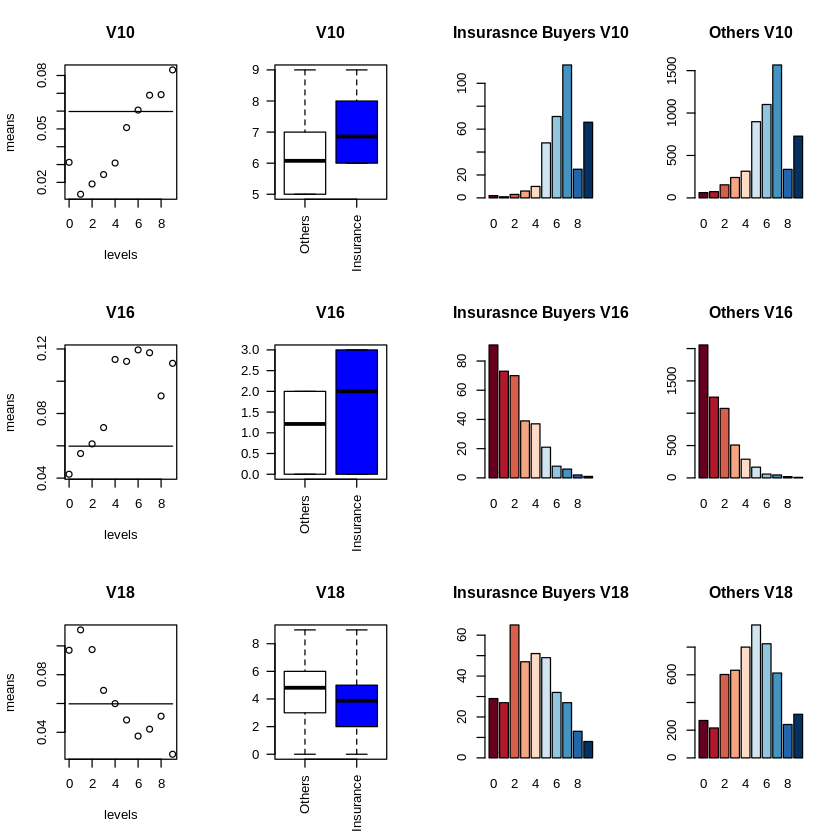

In [24]:
plotFeature(1,3)

V10,which assesses the likelihood of being married, seemed to have an almost linear positive association with the probability of buying insurance. The typical insurance buyer was more likely to be married, with a median value of 7 for insurance buyers, compared to 6 for non-insurance buyers. The frequency distribution of insurance vs non-insurance buyers are quite similar; except, insurance buyers have a thinner left tail.

V16 -likelihood of having a high-level education- has a position linear relationship up till level 4. At which point, the probability of buying insurance spikes. All higher levels then remain essentially constant at this value (with the exception of 8).

V18 -likelihood of having a low-level education- The frequency distribution of insurance buyers seems to almost be the reverse of the distrbution of non-insurance buyers. Additionally, there is a substantial difference between levels 0-2 and other levels where there is a big dip in probability of buying insurance. In levels 3-8 the relationship between level and probability of buying insurance decreases then increases again in a "V" shape. 


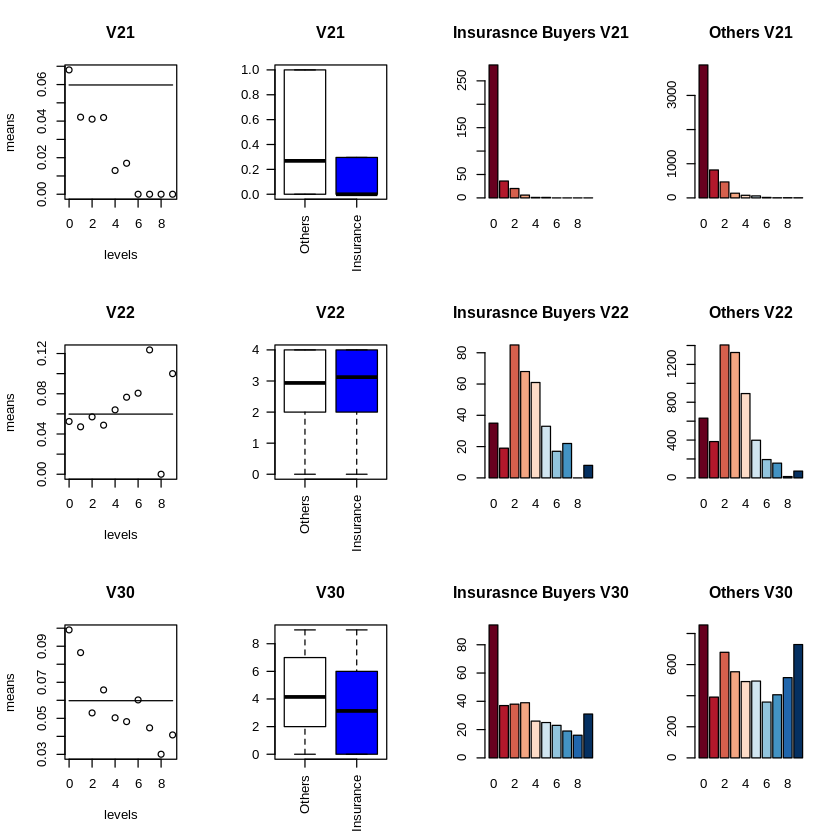

In [134]:
plotFeature(4,6)

V21 -likelihood of being a farmer- is similar to a step function, with steps at 0, 1-3, 4-5 and 6-9. In general, a higher likelihood of being a farmer meant a lower likelihood of buying insurance. Both distributions have a high right skew, although the skew is slightly less for insurance buyers.

V22 -likelihood of being middle management- the median is close for both insurance and non-insurance buyers. Something interesting happens whereby the probility of buying insurance increases gradually then has a massive jump at level 7, followed by a massive drop at level 8.

V30 -likelihood of renting house- there is a negative almost linear association between level and the probability of buying insurance. Similarly, the frequency of insurance buyers is typically decreasing from levels 0-8, whilst for non-insurance buyers there is leess of a trend.

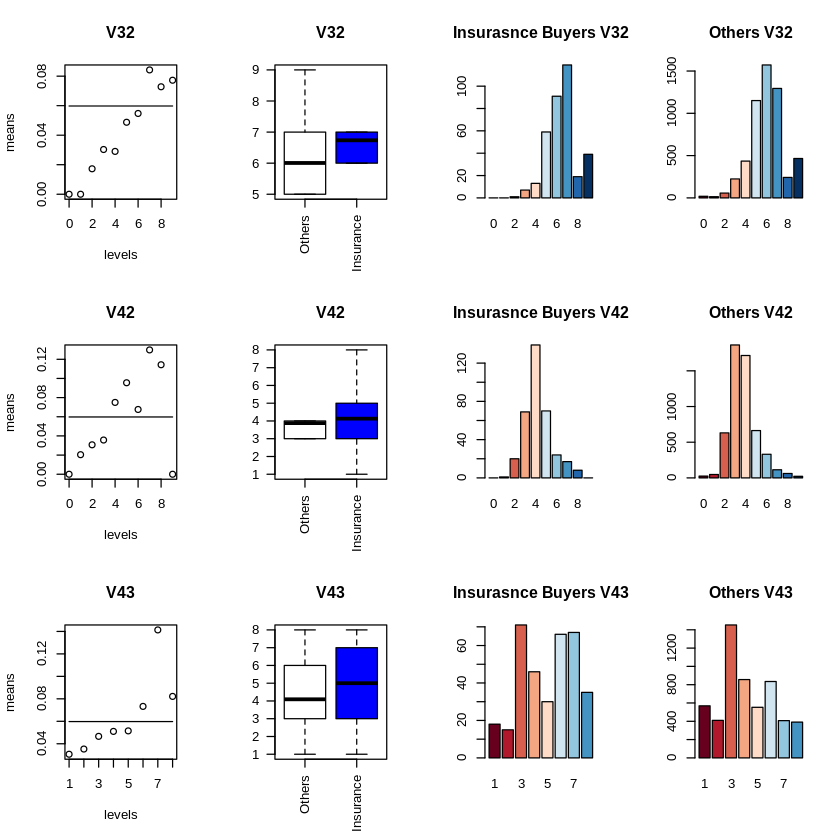

In [135]:
plotFeature(7,9)

V32 -likelihood of having 1 car- There is a strongly linear positive association between level and probability of buying insurance.

V42 -average income- between levels 0-8, there is strongly linear positive association between level and probability of buying insurance. In level 9 there is a massive drop. We can treat this as an outlier as there appears to be a small sample size of customers in level 9. In terms of frequency distribution, insurance buyers have a higher and thinner peak. Additionally, insurance group has a fatter right tail.

V43 -purchasing power class- there is a positive association between level and probability association. The relationshyip would be linear, except there is a big spike in level 7. 

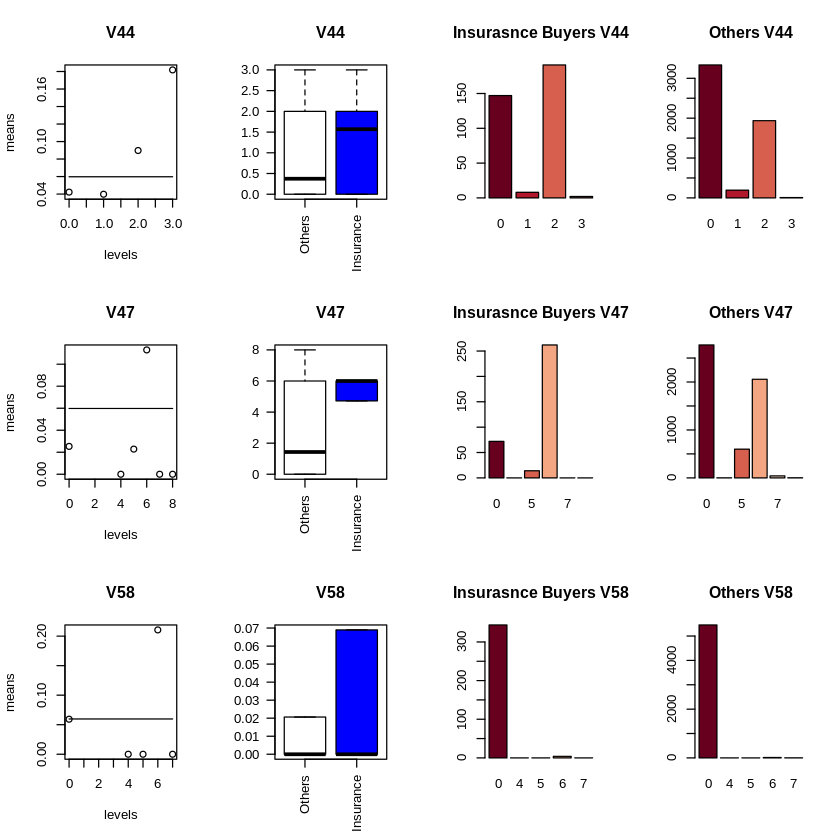

In [143]:
plotFeature(10,12)

V44 -contribution to private third-party insurance- customers with higher contribution to third-party insurance were much more likely to buy insurance. Specifically, there is big jump in probability to buy insurance at level 2, and then anouther significant jump at level 3.

V47- contribution to car policies- there is no clear relationship between level of contribution to car policies and probability of buying insurance. At level 6 customers had relatively very high probability of buying insurance. Alternatively, customers at levels 4,7 and 8 had a relatively very low probability of buying insurance.

V58 -contribution disability insurance policies- similar to V47, we have no clear relationship. There is a spike at level 6, while customers at level 4,5 and 7 had a relatively low probability of buying insurance.

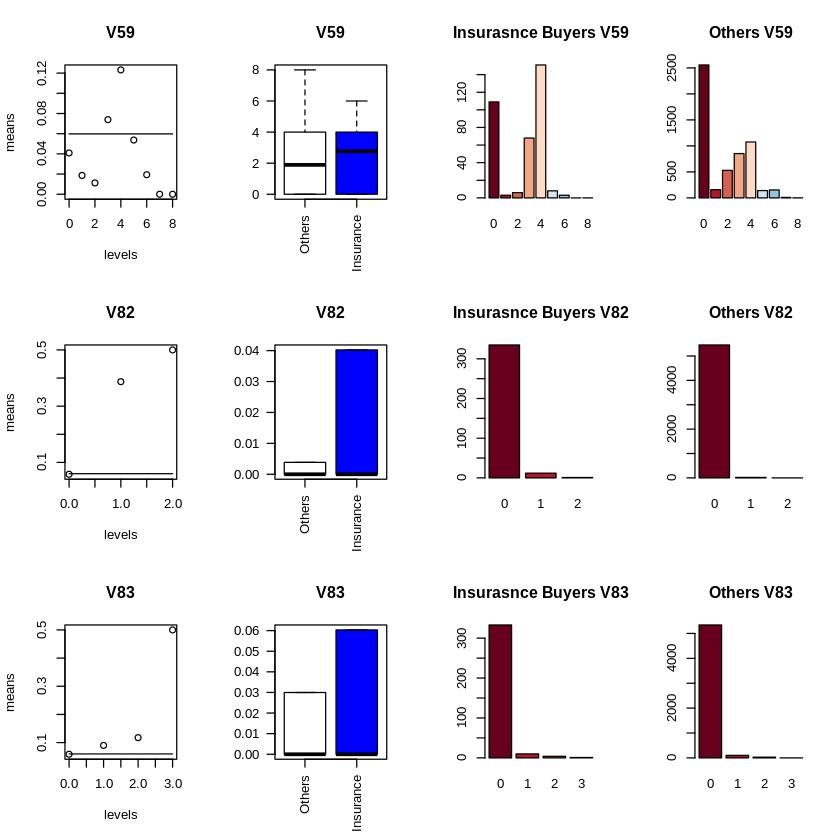

In [149]:
plotFeature(13,15)

V59 -contribution to fire policies- customers at level had a relatively high probability of buying insurance, while customers at 1-2 and 6-8 had a relatively low probability of buying insurance.

V82 -number of boat policies- customers with higher boat policies had a greater chance of buying insurance. At levels 1 and 2 they had a greater than 40% chance of buying insurance.

V83 -number of bicycle policies- there is a positive association with number of bicily policies and buying caravan insurance. There is a big spike at 3 where customers had a 50% chance of buying insurance.

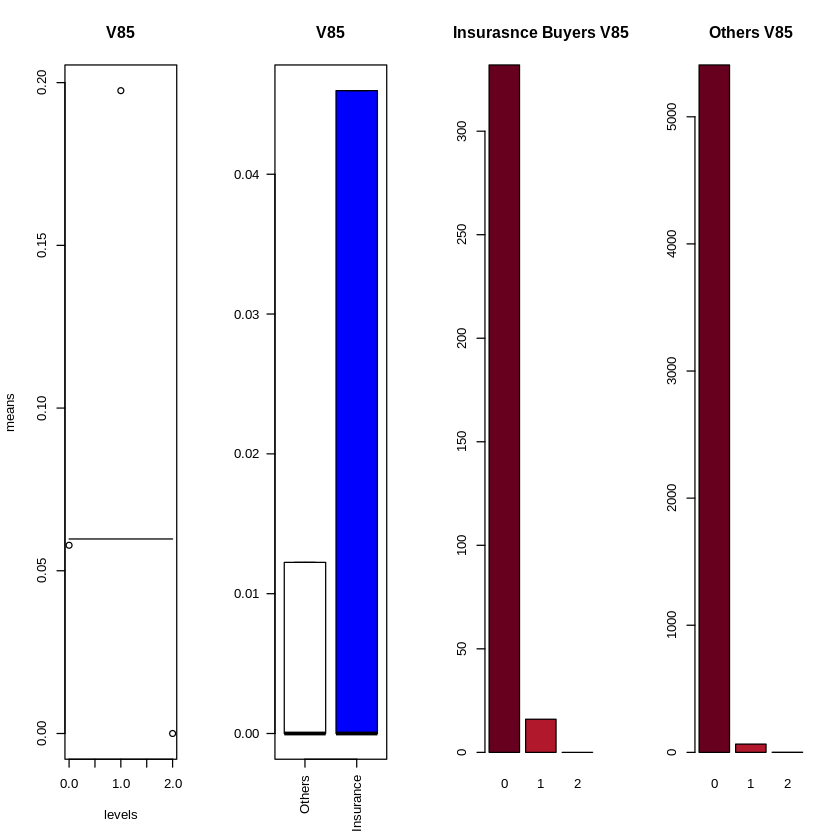

In [157]:
plotFeature(16,16,1,4)

V85 -number of social security policies- customers at 1 had a relatively high probability of buying insurance, while customers at 2 had a relatively low probability of buying insurance.

#### iii) Pair-wise Exploration
Let us have a look at how the variables correlate with each other.

In [310]:
cor(train[,variables])

,V10,V16,V18,V21,V22,V30,V32,V42,V43,V44,V47,V58,V59,V82,V83,V85
V10,1.000000000,0.0750378771,-0.081953565,0.01976130,-0.007195562,-0.390995695,0.416807203,0.35311794,0.32620754,-0.039009643,0.0261078292,0.012914339,0.05845288,-0.001565529,0.020921355,0.036568846
V16,0.075037877,1.0000000000,-0.638593595,-0.12538006,0.041373762,-0.230687287,0.137947981,0.42544478,0.39803791,0.049364606,-0.0008229176,-0.012173311,0.02694534,0.007604593,0.040493383,0.040344642
V18,-0.081953565,-0.6385935955,1.000000000,0.12490900,-0.314114827,0.265143906,-0.183971700,-0.41708231,-0.44787878,-0.044483581,-0.0035712701,0.007284532,-0.01693711,-0.019264256,-0.035398310,-0.052650418
V21,0.019761300,-0.1253800585,0.124909002,1.00000000,-0.284217141,-0.190318500,-0.160440119,-0.03965188,-0.10792407,-0.069730679,-0.0399108639,0.026611330,0.08699957,-0.006533920,-0.028990073,-0.028923878
V22,-0.007195562,0.0413737624,-0.314114827,-0.28421714,1.000000000,0.017751768,0.175766157,0.11446088,0.13836240,0.024106898,0.0107948913,-0.002031374,-0.01174167,0.007475484,-0.001910115,0.033760681
V30,-0.390995695,-0.2306872871,0.265143906,-0.19031850,0.017751768,1.000000000,-0.187570355,-0.42551986,-0.42751756,-0.015981567,-0.0086108887,-0.030147451,-0.18273235,-0.026083740,-0.030262408,-0.037379242
V32,0.416807203,0.1379479815,-0.183971700,-0.16044012,0.175766157,-0.187570355,1.000000000,0.22631209,0.27016710,0.024208744,0.0473851313,-0.008410818,0.02039755,-0.010046326,0.029119401,0.032868304
V42,0.353117943,0.4254447759,-0.417082305,-0.03965188,0.114460880,-0.425519857,0.226312085,1.00000000,0.45222107,0.020381246,0.0240995144,-0.012668413,0.07969039,0.012048674,0.032672930,0.048770498
V43,0.326207541,0.3980379085,-0.447878781,-0.10792407,0.138362399,-0.427517565,0.270167105,0.45222107,1.00000000,0.012215097,0.0225545491,0.017703186,0.10006205,0.019636017,0.041084402,0.064468039
V44,-0.039009643,0.0493646057,-0.044483581,-0.06973068,0.024106898,-0.015981567,0.024208744,0.02038125,0.01221510,1.000000000,0.1545395977,-0.001745933,0.48485428,-0.002178718,-0.002271528,0.046280758


In [12]:
colorRange <- c('#69091e', '#e37f65', 'white', '#aed2e6', '#042f60')
## colorRamp() returns a function which takes as an argument a number
## on [0,1] and returns a color in the gradient in colorRange
myColorRampFunc <- colorRamp(colorRange)

panel.cor <- function(w, z, ...) {
    correlation <- cor(w, z)

    ## because the func needs [0,1] and cor gives [-1,1], we need to shift and scale it
    col <- rgb(myColorRampFunc((1 + correlation) / 2 ) / 255 )

    ## square it to avoid visual bias due to "area vs diameter"
    radius <- sqrt(abs(correlation))
    radians <- seq(0, 2*pi, len = 50) # 50 is arbitrary
    x <- radius * cos(radians)
    y <- radius * sin(radians)
    ## make them full loops
    x <- c(x, tail(x,n=1))
    y <- c(y, tail(y,n=1))

    ## trick: "don't create a new plot" thing by following the
    ## advice here: http://www.r-bloggers.com/multiple-y-axis-in-a-r-plot/
    ## This allows
    par(new=TRUE)
    plot(0, type='n', xlim=c(-1,1), ylim=c(-1,1), axes=FALSE, asp=1)
    polygon(x, y, border=col, col=col)
}

# usage e.g.:
# pairs(mtcars, upper.panel = panel.cor)

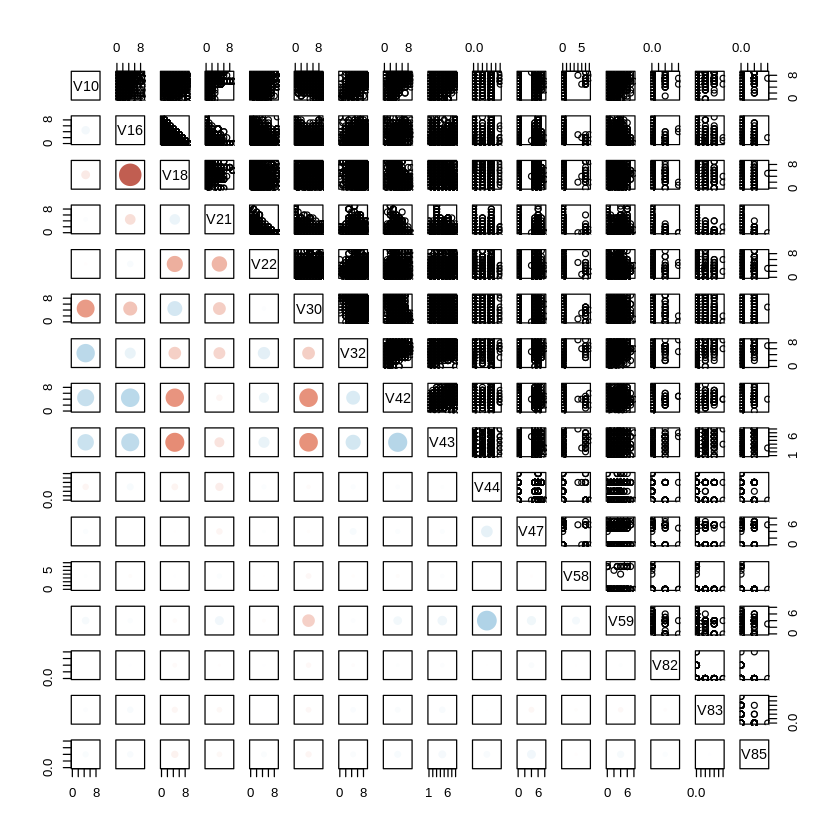

In [37]:
pairs(train[,variables], lower.panel=panel.cor)

As expect there does not seem to be too much correlation between these variables. This due to the lasso regression we performed earlier. The pair we might need to account for is V16 and V18 which has a correlation of -0.64.

## 3. Model Development<a class="anchor" id="sec_3"></a>

Let us run a regression with all the variables to see which are significant.

In [12]:
train2=train
# convert each column into factor
for (col in names(train)){
    train2[,col]=factor(train2[,col])   
}

In [13]:
fit.glm <- glm(as.formula(paste("V86~", paste(variables, collapse="+"))), data=train2, family = "binomial")
summary(fit.glm)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = as.formula(paste("V86~", paste(variables, collapse = "+"))), 
    family = "binomial", data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9273  -0.3557  -0.2237  -0.1388   3.1730  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.335e+01  1.111e+03  -0.030 0.976054    
V101        -1.155e+00  1.349e+00  -0.856 0.392068    
V102        -7.729e-01  1.040e+00  -0.743 0.457533    
V103        -4.669e-01  9.609e-01  -0.486 0.627023    
V104        -4.152e-01  9.269e-01  -0.448 0.654159    
V105         1.462e-01  8.820e-01   0.166 0.868379    
V106         1.141e-01  8.854e-01   0.129 0.897450    
V107         3.619e-02  8.861e-01   0.041 0.967426    
V108         1.032e-01  9.076e-01   0.114 0.909436    
V109         2.799e-01  8.883e-01   0.315 0.752693    
V161         4.418e-01  1.986e-01   2.224 0.026135 *  
V162         4.553e-02  2.113e-01   0.215 0.829394    
V163        -3.053e-02  2.650e-01

Several of the variables seem to be insignificant. We will take them our of our model; however, we will leave V18 in, to see if the interaction is significant to our prediction model.

In [14]:
fit.glm2=glm(V86 ~ V16+ V47+ V58 +V18+ V16:V18+ V59 + V82 + V83 + V85, data=train2, family = "binomial")
summary(fit.glm2)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = V86 ~ V16 + V47 + V58 + V18 + V16:V18 + V59 + V82 + 
    V83 + V85, family = "binomial", data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8141  -0.3712  -0.2279  -0.1534   3.2437  

Coefficients: (45 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -3.60630    0.56609  -6.371 1.88e-10 ***
V161         -15.07778 1219.56281  -0.012 0.990136    
V162           0.11389    0.68031   0.167 0.867052    
V163         -15.02598  681.14706  -0.022 0.982400    
V164          -0.27838    0.92797  -0.300 0.764188    
V165          -0.15789    0.72845  -0.217 0.828404    
V166           0.94634    0.75169   1.259 0.208044    
V167           1.37512    0.88800   1.549 0.121489    
V168         -14.50636 1366.33203  -0.011 0.991529    
V169           0.15801    1.24107   0.127 0.898686    
V474         -13.59212 3956.18035  -0.003 0.997259    
V475          -0.05879    0.30768  -0.191 0.

The interaction turned out to be insignificant. Below is our final model which consists of:

* V16- Likelihood of high education
* V47- Contribution to car policies
* V58- Contribution to disability insurance policies
* V59- Contribution to fire policies
* V82- Number of boat policies
* V83- Number of bicycle policies 
* V85- Number of social security insurance policies

With the shortened selection of features, the AIC of the logistic regression model reduced from 2412 to 2332.

In [15]:
fit.glm3=glm(V86 ~ V16+ V47+ V58 + V59 + V82 + V83 + V85, data=train2, family = "binomial")
summary(fit.glm3)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = V86 ~ V16 + V47 + V58 + V59 + V82 + V83 + V85, 
    family = "binomial", data = train2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5326  -0.3859  -0.2472  -0.1630   3.2989  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -4.31508    0.17301 -24.941  < 2e-16 ***
V161           0.39173    0.16732   2.341 0.019217 *  
V162           0.31139    0.17017   1.830 0.067268 .  
V163           0.47492    0.20644   2.301 0.021418 *  
V164           0.88037    0.21476   4.099 4.14e-05 ***
V165           0.97159    0.27169   3.576 0.000349 ***
V166           1.12258    0.41044   2.735 0.006238 ** 
V167           0.96065    0.46983   2.045 0.040887 *  
V168           0.87022    0.78006   1.116 0.264602    
V169           0.89540    1.11734   0.801 0.422919    
V474         -12.64272 2399.54473  -0.005 0.995796    
V475          -0.06135    0.30471  -0.201 0.840427    
V476           1.44348    0.14126  10.219  < 2e

## 4. Model Evaluation<a class="anchor" id="sec_4"></a>

Let us see how our model fared. First, we will prepare our test dataset by removing factors which did not occur in the training dataset.

In [16]:
# convert columns to factors
test2=test[,-c(1,5)]
for (col in names(test2)){  
   test2[,col]=as.factor(test2[,col]) 
}
# remove levels which occurred in the test dataset but not training dataset
for (col in names(test2)){
    for (val in unique(test2[,col])){
        if (!(val %in% unique(train2[,col]))){
            test2=test2[test2[,col]!=val,]
        }
    }
}


The model's top 800 customers most likely to buy caravan insurance actually bought insurance 14.9% of the time.

In [17]:
probs1 <- predict(fit.glm3, test2, type = "response")

# obtain top 800 customers 
pred.glm=names(sort(probs1,decreasing = TRUE))[seq(1,800)]
mean(target[pred.glm,])

[1] 0.14875

## 5. Variable Identification and Conclusion <a class="anchor" id="sec_5"></a>

In addition to viewing coefficients and p-values we can use the function **varimp** to identify the most important variables.

In [182]:
imp=varImp(fit.glm3)
# obtain rows in descending order
order=order(imp,decreasing = TRUE)
cbind(row.names(imp)[order],imp[order,])[1:10,]

V476,10.2187820263754
V594,6.59149131756835
V821,5.92767511481849
V164,4.0993236524696
V586,3.72809487014206
V165,3.57608331040762
V593,3.54125421273497
V851,2.75600017126477
V166,2.73502300141788
V592,2.63982153974938


Above, we can see that 1 variable is significant.

According to our logistic model, by quite a distance, the most important variable in determining the probaility of buying caravan insurance V47, the contribution to car policies at level 6.

After this some of the more important variables are:
- V59- Contribution to fire policies, at level 4
- V82- Number of boat policies, at level 1
- V16 - High education, at level 4

In general, the most important factor in determining likelihood to buy caravan insurance, is the individual's predisposition towards insurance policies -- 6 of the 7 features, and the top 3 most important variables,  in the final model all had to do with insurance policies.


Based of our exploration in section 2, we saw a general profile for customers who buy caravan insurance. These were customers who were likely married, wealthier, better educated and own a car. This is the customer profile, the company should target.

## 6. References <a class="anchor" id="sec_7"></a>

Francis, et al. “Penalized Logistic Regression Essentials in R: Ridge, Lasso and Elastic Net.” STHDA, 11 Mar. 2018, www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/.